# [NTDS'18] milestone 4: graph signal processing
[ntds'18]: https://github.com/mdeff/ntds_2018

[Rodrigo Pena](https://people.epfl.ch/254838), [EPFL LTS2](http://lts2.epfl.ch)

### Students

* Team: 37
* Students: Isabela Constantin, Adélie Garin, Celia Hacker, Michael Spieler
* Dataset: wikipedia

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective

The goal of this milestone is to do some Graph Signal Processing (GSP) on the data of your project.

### A note about plotting

There are several questions in this milestone that ask you to plot a signal on your network.
There are several ways from which you could approach it.
In all cases, compute the position of the nodes a single time at the beginning, as this is likely to be a costly operation.
Using a single layout for all the graph plots will also make it easier to compare the plots.
Indeed, the only thing changing between plots is the signal displayed.
You can represent the features/labels lying on the graph via node **colors**.
To do so, make sure to have a consistent color map throughout and remember to display a colorbar and scale in all plots, so that we can tell what numbers the colors represent.

* An option is to use the **Laplacian eigenmaps** that you have seen in the previous milestone to embed your graph on the plane. For example:
  ```
  from matplotlib import pyplot as plt
  plt.scatter(eigenvectors[:, 1], eigenvectors[:, 2], c=signal, alpha=0.5)
  plt.colorbar()
  ```
* Another option is to use the plotting capabilities of **[NetworkX](https://networkx.github.io)**.
  See the documentation of its [drawing methods](https://networkx.github.io/documentation/stable/reference/drawing.html).
  For example:
  ```
  import networkx as nx
  graph = nx.from_scipy_sparse_matrix(adjacency)
  coords = nx.spring_layout(graph)  # Force-directed layout.
  coords = eigenvectors[:, 1:3]  # Laplacian eigenmaps.
  nx.draw_networkx_nodes(graph, coords, node_size=60, node_color=signal)
  nx.draw_networkx_edges(graph, coords, alpha=0.3)
  ```
* Another option is to use the plotting capabilities of the **[PyGSP](https://github.com/epfl-lts2/pygsp)**, a Python package for Graph Signal Processing.
  **Note that your are forbidden to use the PyGSP for anything else than plotting.**
  See the documentation of its [plotting utilities](https://pygsp.readthedocs.io/en/stable/reference/plotting.html).
  For example:
  ```
  import pygsp as pg
  graph = pg.graphs.Graph(adjacency)
  graph.set_coordinates('spring')  # Force-directed layout.
  graph.set_coordinates(eigenvectors[:, 1:3])  # Laplacian eigenmaps.
  graph.plot_signal(signal)
  ```
* Yet another option is to save your graph on disk, use **[Gephi](https://gephi.org)** externally, to visualize the graph, save the graph with the Gephi coordinates and finally load the nodes coordinates back into the notebook.

We encourage you to try all the above methods before making your choice. Then be consistent and use only one throughout the milestone.
NetworkX and PyGSP should already be installed in your environement. If that's not the case, install with `conda install networkx pygsp` (after activating the `ntds_2018` environment).

## 0 - Load your network

In [1]:
%matplotlib inline

If you get a `No module named 'pyunlocbox'` error when running the below cell, install the [pyunlocbox](https://github.com/epfl-lts2/pyunlocbox) with `conda install pyunlocbox` (after activating the `ntds_2018` environment).

In [2]:
import numpy as np
from scipy import sparse
import scipy.sparse.linalg
from matplotlib import pyplot as plt
from pyunlocbox import functions, solvers
import pandas as pd
import networkx as nx

For this milestone, all we will need is a set of features/labels for each of the nodes on the network, as well as the Laplacian, $L,$ and Gradient, $\nabla_G,$ matrices that you have computed for your network while working on milestone 3.

Import those objects in the cell below (or recompute the Laplacian and Gradient from your stored adjacency matrix, if you wish).

_Note_: If your features/labels are not floating-point numbers, please convert them. For example, if your data has labels "cat" and "dog" for nodes that represent cats or dogs, respectively, you may assign the number `1.0` for the label "cat" and the number `-1.0` for the label "dog".  

In [3]:
# Load adjacency matrix from the largest connected component 
adjacency= np.load('../milestone3/largest_wcc.npz')['arr_0']
#note: our graph contains selfloops. To compute the Laplacian and do the work below, we delete them (as per slides)
adjacency = adjacency - np.diag(np.diag(adjacency))
n_nodes = adjacency.shape[0] # the number of nodes in the network 
n_edges =  int(np.sum(adjacency)/2) # the number of edges in the network

In [4]:
# compute combinatorial laplacian 
degree_matrix = sparse.spdiags(np.sum(adjacency,axis=0), 0, n_nodes, n_nodes)
adjacency = sparse.csr_matrix(adjacency)
laplacian_combinatorial =  degree_matrix - adjacency

In [5]:
# compute normalised laplacian
# first compute D^(-1/2),we can make it into a matrix after
D_inv_sq = 1 / np.sqrt(np.sum(adjacency,axis=0))
D_inv_sq = sparse.spdiags(D_inv_sq, 0, n_nodes, n_nodes)
laplacian_normalized = sparse.eye(n_nodes) - D_inv_sq @ adjacency @ D_inv_sq

In [6]:
def comput_S(adjacency):
    n_nodes = adjacency.shape[0]
    n_edges =  int(np.sum(adjacency)/2)
    S = np.zeros((n_nodes,n_edges*2), dtype=int)
    k=0
    nodes = np.argwhere(adjacency!=0)
    for i,j in nodes:
        wij = adjacency[i,j]
        S[i, k] = wij
        S[j, k] = -wij
        k += 1 # increment the edge index
    S = sparse.csr_matrix(S)
    return S

In [7]:
#S = comput_S(adjacency)
#sparse.save_npz('S.npz', S)

In [8]:
S = sparse.load_npz('S.npz')
S

<4589x213068 sparse matrix of type '<class 'numpy.int64'>'
	with 426136 stored elements in Compressed Sparse Row format>

In [9]:
# gradient for combinatorial laplacian
gradient = S.T # = S.T where rows= edges , columns = nodes 
gradient = sparse.csr_matrix(gradient)
S = sparse.csr_matrix(S)


In [10]:
#L=np.matmul(S,gradient)/2
L = S.dot(gradient)/2 #not normalized, need to check it corresponds to our previous laplacian
np.allclose(L.A, laplacian_combinatorial.A, atol=1e-9)

True

Note: since we had multiple labels stemming from wikipedia categories, in order to have a binary label, we decided to split our nodes into the following types: ones that have the most common label ('Science') and all the others. 

In [11]:
# find a useful label
labels_all = np.load('labels.npz')['label_id']
label_names = np.load('labels.npz')['label_str']
most_common_label = np.argmax(np.bincount(labels_all))
print(f'most common label: "{label_names[most_common_label]}"')

# create label vector
labels = np.where(labels_all == most_common_label, 1, 0)

most common label: "Science"


## 1 - Graph Fourier Transform 
In this section we will observe how your feature/label vector looks like in the "Graph Fourier" domain.

### Question 1

Compute the Fourier basis vectors and the Laplacian eigenvalues. Make sure to order those from smaller to larger, $\lambda_0 \leq \lambda_1 \leq \dots \leq \lambda_{N-1},$ and use the same ordering for the Fourier basis vectors.

**Note: here we took the eigenvectors and eigenvalues of the combinatorial laplacian**

In [12]:
eigenvalues_comb, eigenvectors_comb = np.linalg.eigh(laplacian_combinatorial.toarray())
e = eigenvalues_comb # Ordered Laplacian eigenvalues.
U = eigenvectors_comb # Ordered graph Fourier basis.

In [13]:
eigenvalues_norm, eigenvectors_norm = np.linalg.eigh(laplacian_normalized.toarray())
eigenvectors_renorm = D_inv_sq @ eigenvectors_norm # renormalize for eigenmap visualization

In [14]:
U[:,3]

array([-7.95782643e-05, -7.86830474e-05, -7.97472448e-05, ...,
       -8.93808615e-05, -7.91710093e-05, -8.13718434e-05])

In [15]:
# ensure it is sorted
(np.sort(e) == e).all()

True

In [16]:
U[:,0]

array([0.01476186, 0.01476186, 0.01476186, ..., 0.01476186, 0.01476186,
       0.01476186])

**Note: the visualisations are hard to make with the eigenvectors of the combinatorial laplacian: there will be big hubs with high signals, but most of them will be small. Demonstration below. Therefore, we thought it would be more more meaningful to plot the eigenvectors of the normalised laplacian.** 

In [17]:
laplacian_combinatorial.dot(U[:,n_nodes-1]).dot(U[:,n_nodes-1]) 

1622.0182828042207

In [18]:
laplacian_combinatorial.dot(U[:,1]).dot(U[:,1])

0.8720903145897625

Plot the first 3 and the last Fourier basis vectors as signals on your graph. Clearly indicate which plot belongs to which basis vector.

In [19]:
def plot_fourier(eigenvector, title):
    n_eigenvector = eigenvector.shape[0]
    plt.plot(range(n_eigenvector),eigenvector, 'o', c='blue', markeredgecolor='none', markersize= 1)
    plt.xlabel('The n-th node')
    plt.ylabel('Signal value')
    plt.title(title)

In [20]:
# separate helper function to compute the position of the nodes, as it's costly operation
def plot_graph_adj(adjacency, eigenvectors):
    graph = nx.from_scipy_sparse_matrix(adjacency)
    coords_spring = nx.spring_layout(graph)  # Force-directed layout.
    coords = eigenvectors[:, 1:3]  # Laplacian eigenmaps.
    return graph, coords, coords_spring

In [21]:
def plot_graph(graph, coords, signal):
#    node_color = [signal[n] for n in range(graph.number_of_nodes())]
    node_color = signal
    nc = nx.draw_networkx_nodes(graph, coords, node_size=1, node_color=node_color) 
    #nx.draw_networkx_edges(graph, coords, alpha=0.1)
    plt.colorbar(nc)    

In [22]:
if 'graph' not in globals():
    graph, coords, coords_spring = plot_graph_adj(adjacency, eigenvectors_renorm)

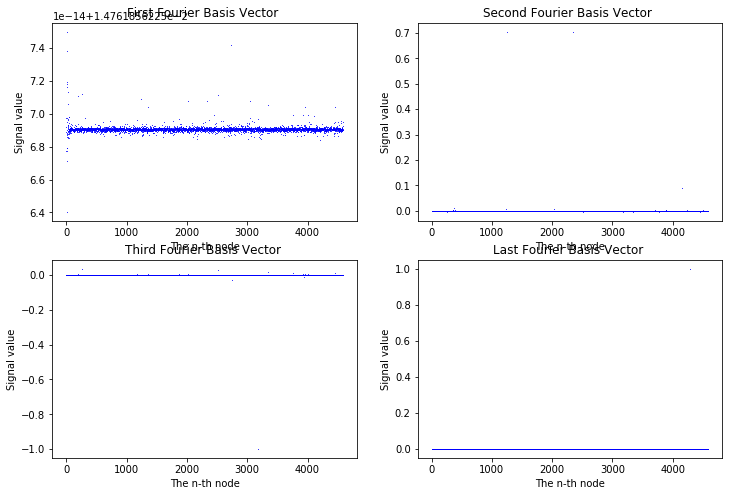

In [23]:
#Plot on the same scale! 
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plot_fourier(U[:,0], 'First Fourier Basis Vector ')
plt.subplot(2,2,2)
plot_fourier(U[:,1], 'Second Fourier Basis Vector ')
plt.subplot(2,2,3)
plot_fourier(U[:,2], 'Third Fourier Basis Vector ')
plt.subplot(2,2,4)
plot_fourier(U[:,n_nodes-1], 'Last Fourier Basis Vector ')


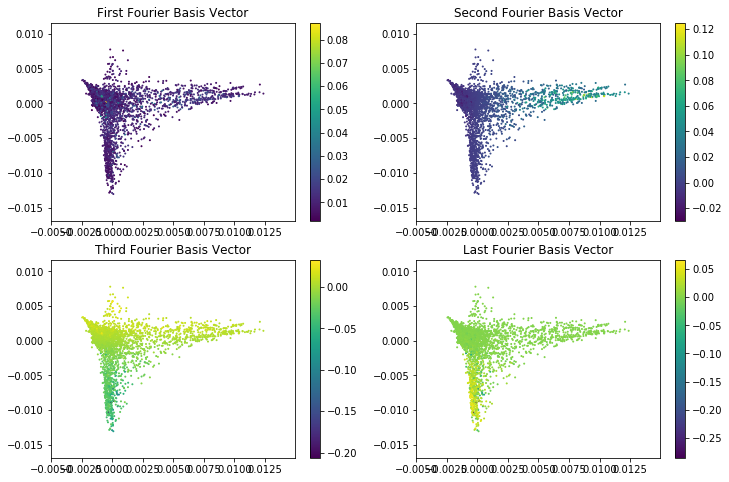

In [24]:
c = coords
# c = coords_spring
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plot_graph(graph, c, eigenvectors_norm[:,0]); plt.title('First Fourier Basis Vector')
plt.subplot(2,2,2)
plot_graph(graph, c, eigenvectors_norm[:,1]); plt.title('Second Fourier Basis Vector')
plt.subplot(2,2,3)
plot_graph(graph, c, eigenvectors_norm[:,2]); plt.title('Third Fourier Basis Vector')
plt.subplot(2,2,4)
plot_graph(graph, c, eigenvectors_norm[:,-1]); plt.title('Last Fourier Basis Vector');


### Question 2

What can you observe in terms of local variations when comparing the basis vectors corresponding to the smallest eigenvalues to those corresponding to the largest eigenvalue? How would this justify the interpretation of the eigenvalues as "graph frequencies"?

**Answer:**
The vectors corresponding to the smallest eigenvalues have a smaller range and they divide the graph in a spacially smoother way (looking at the projection).
The first eigenvectors correspond to "low graph frequencies" while the last eigenvectors correspond to "high graph frequencies"

### Question 3

Implement a function that returns the Graph Fourier Transform (GFT) of a given vector $x \in \mathbb{R}^{N},$ with respect to your graph, and a function that computes the corresponding inverse GFT (iGFT).

In [25]:
def GFT(x):
    return  np.matmul(U.T,x) # U.T= U^-1 because orthonormal 

def iGFT(x):
    return np.matmul(U,x) 

### Question 4

Plot your feature/label vector as a signal on your graph

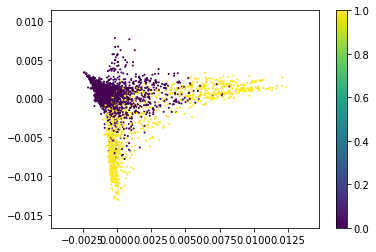

In [26]:
plot_graph(graph, coords, labels);

Plot the absolute values of the GFT of your feature/label signal as a function of the graph eigenvalues. Make sure to add a marker indicating the position of each graph eigenvalue, and remember to properly name the axes.

Text(0.5, 1.0, 'Values of transformed labels')

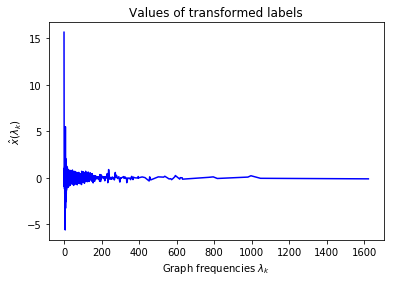

In [27]:
fig = plt.figure()
ax = plt.gca()
ax.plot(e,GFT(labels), c='blue', markeredgecolor='none')
plt.xlabel('Graph frequencies $\lambda_k$')
plt.ylabel('$\^x(\lambda_k)$')
plt.title('Values of transformed labels')



It seems like the 400 first frequencies are the most interesting so we plot only the 400 first below

Text(0.5, 1.0, 'Values of transformed labels for first 400 frequencies')

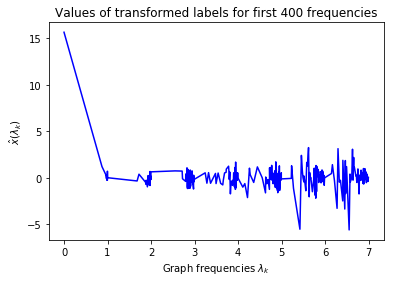

In [28]:
fig = plt.figure()
ax = plt.gca()
ax.plot(e[:400],GFT(labels)[:400], c='blue', markeredgecolor='none')
plt.xlabel('Graph frequencies $\lambda_k$')
plt.ylabel('$\^x(\lambda_k)$')
plt.title('Values of transformed labels for first 400 frequencies')


### Question 5

Discuss the behavior of the GFT that you plotted in the last question via comparing the plot of your label signal and those of the Fourier basis of Question 1. Would you consider your labels a "low-pass" or "high-pass" signal, or yet something else entirely?

**Answer:**
The label signal looks smooth (or "low-pass" if you want) because the biggest components in the GFT correspond to the first eigenvectors.

## 2 - Filtering on graphs

In this section we will check how filtered Dirac impulses diffuse on your graph.

### Question 6 

Implement the following three filter kernels and the graph filtering operation.

- The **heat kernel** is supposed to take in a vector of eigenvalues `e` and a parameter `t` and output a vector of evaluations of the heat kernel at those eigenvalues (see the course slides for help).
- The **inverse filter** kernel is supposed to take in a vector of eigenvalues `e` and a parameter `t` and implement spectrally the  filter defined in the node domain by $f_{out}  = (I + t L)^{-1} f_{in},$ where $f_{in}, f_{out} \in \mathbb{R}^{N}$ are, repectively, the input and output signals to the filter.
- The **rectangle kernel** takes in a vector of eigenvalues `e` and parameters `l_min` and `l_max` and returns `1.0` at coordinates satisfying $(e[l] \geq l_{min}) \wedge (e[l] \leq l_{max}),$ and `0.0` otherwise.
- The **graph filtering** operation takes a graph signal $x \in \mathbb{R}^{N}$, a spectral graph `kernel` and a set of keyworded variables, and returns the corresponding filtered signal.
    - _Hint:_ Remember that you have implemented the `GFT` and `iGFT` operations in Question 3.
    - The `**kwargs` is a placeholder to collect supplementary pairs of keyword-values that are not known by the implementation before execution time.
      The `kwargs` variable is a dictionary whose keyes and values are the parameter names and values.
      This is useful to allow both `graph_filter(x, heat_kernel, tau=1.0)` and `graph_filter(x, rectangle_kernel, lambda_min=0.0, lambda_max=1.0)` to be valid calls from the same implementation.
      One can then defer the keyword-value assignment to the `kernel` call: `foo = kernel(bar, **kwargs)`.

In [29]:
def heat_kernel(e, t):
    return np.exp(-t*e)

def inverse_kernel(e, t):
    '''
    (I + t*L)^-1 = U @ diag(g) @ U.T
    g = diag(U.T @ (I + t*L)^-1 @ U)

    dumb solution:
    g = np.diag(U.T @ np.linalg.inv(I + t*L) @ U)

    simplification using: U^-1 = U.T and L = U @ diag(e) @ U.T
    (U.T @ (I + t*L)^-1 @ U)^-1 = U^-1 @ (I + t*L) @ U.T^-1
    ... = U.T @ (I + t*L) @ U
    ... = U.T @ U + U.T @ t*L @ U
    ... = I + t * U.T @ L @ U
    ... = I + t * diag(e)
    diag(g) = (I + t*diag(e))^-1
    g = 1/(1 + t*e)
    '''
    g = 1/(1 + t*e)
    return g

def rectangle_kernel(e, l_min, l_max):
    cond = np.logical_and(e >= l_min, e <= l_max)
    return np.where(cond, 1, 0)

def graph_filter(x, kernel, **kwargs):
    e = eigenvalues_comb
    g = kernel(e, **kwargs)
    return iGFT(np.matmul(np.diag(g),GFT(x)))

### Question 7

Plot all three filter kernels in the spectral domain. Remember to properly name the axes and title the plots. Choose filter parameters that best approximate the behavior of the GFT of your feature/label signal (as seen in Question 4).

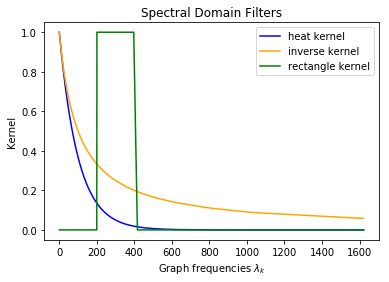

In [30]:
fig = plt.figure()
ax = plt.gca()
ax.plot(e,heat_kernel(e, 0.01), c='blue', label='heat kernel')
ax.plot(e,inverse_kernel(e, 0.01), c='orange',label='inverse kernel')
ax.plot(e,rectangle_kernel(e, 200, 400), c='green', label='rectangle kernel')
plt.xlabel('Graph frequencies $\lambda_k$')
plt.ylabel('Kernel')
plt.title('Spectral Domain Filters')
plt.legend()

### Question 8

Consider two Dirac impulses arbitrarily placed on your graph. Plot their filtered versions by the three filter kernels implemented in Question 6.

In [31]:
dirac = np.zeros(n_nodes)
dirac[np.random.choice(n_nodes, size=2, replace=False)] = 1

In [94]:
heat_filtered = graph_filter(dirac, heat_kernel, t=1)
inverse_filtered = graph_filter(dirac, inverse_kernel, t=1)
rectangle_filtered = graph_filter(dirac, rectangle_kernel, l_min=50, l_max=200)

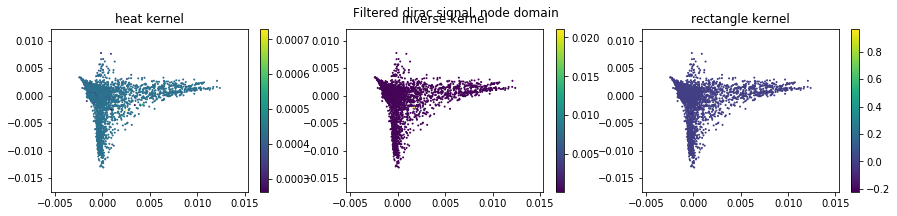

In [95]:
c = coords
plt.figure(figsize=(15,3))
plt.subplot(1,3,1); plot_graph(graph, c, heat_filtered); plt.title('heat kernel')
plt.subplot(1,3,2); plot_graph(graph, c, inverse_filtered); plt.title('inverse kernel')
plt.subplot(1,3,3); plot_graph(graph, c, rectangle_filtered); plt.title('rectangle kernel');
plt.suptitle('Filtered dirac signal, node domain');

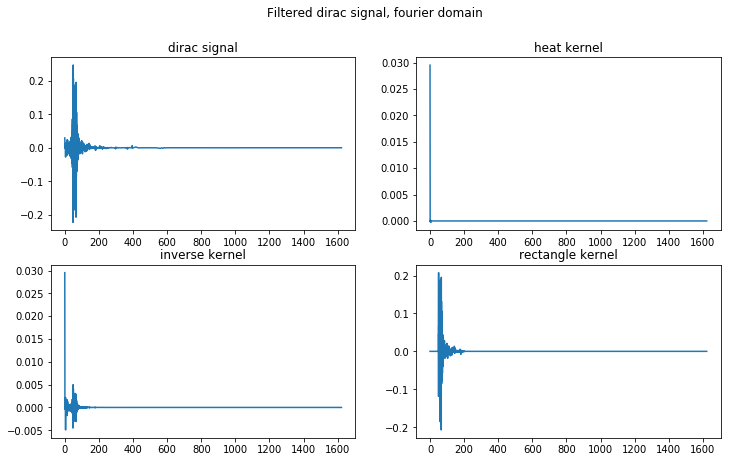

In [96]:
plt.figure(figsize=(12,7))
plt.subplot(2,2,1); plt.plot(e,GFT(dirac)); plt.title('dirac signal')
plt.subplot(2,2,2); plt.plot(e,GFT(heat_filtered)); plt.title('heat kernel')
plt.subplot(2,2,3); plt.plot(e,GFT(inverse_filtered)); plt.title('inverse kernel')
plt.subplot(2,2,4); plt.plot(e,GFT(rectangle_filtered)); plt.title('rectangle kernel');
plt.suptitle('Filtered dirac signal, fourier domain');

We plot them again below with the numbers of the eigenvalues instead of the frequencies to try to visualize better

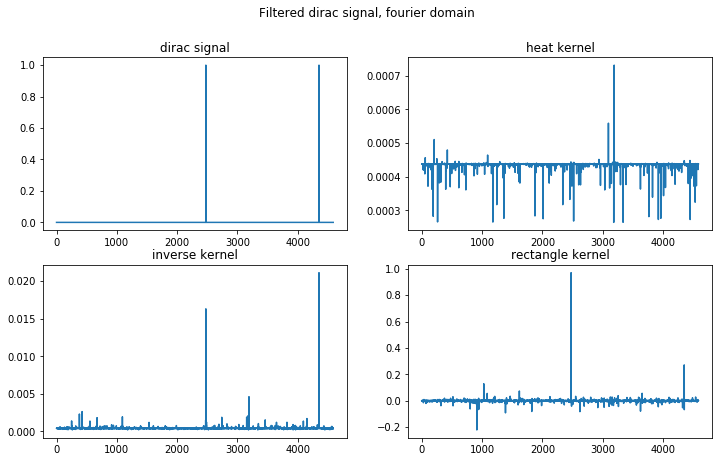

In [97]:
plt.figure(figsize=(12,7))
plt.subplot(2,2,1); plt.plot(dirac); plt.title('dirac signal')
plt.subplot(2,2,2); plt.plot(heat_filtered); plt.title('heat kernel')
plt.subplot(2,2,3); plt.plot(inverse_filtered); plt.title('inverse kernel')
plt.subplot(2,2,4); plt.plot(rectangle_filtered); plt.title('rectangle kernel');
plt.suptitle('Filtered dirac signal, fourier domain');

Comment on the "diffusion" of the Diracs induced by the filters. What does it say about the "communication" of information across your network? Relate that to the network connectivity measures that you analyzed during the previous milestones.

**Answer:**

The heat kernel seems to diffuse the two diracs the most as expected because it corresponds to the heat diffusion model. The rectangular kernel the least.
By testing different random dirac impulses we see that it diffuses wether the nodes we start with are very connected or not. If we start on a node in a hub it will diffuse better than if we start on an isolated node. 


## 3 - De-noising

In this section we will add some centered Gaussian noise to your feature/label signal and attempt to recover it.

### Question 9

In the cell below, set the noise variance $\sigma^2$ by making sure that the signal-to-noise ratio $SNR = \frac{\operatorname{Var}(\text{labels})}{\sigma^2}$ is about  $1.5$.

_Note:_ Actually, you might want to play with the noise variance here and set it to different values and see how the denoising filters behave.

In [36]:
np.var(labels)

0.177632082859326

In [37]:
noise_variance = np.var(labels)/1.5
noisy_measurements = labels + np.sqrt(noise_variance) * np.random.randn(n_nodes)

Text(0.5, 1.0, 'Noisy Measurments in Fourier Domain')

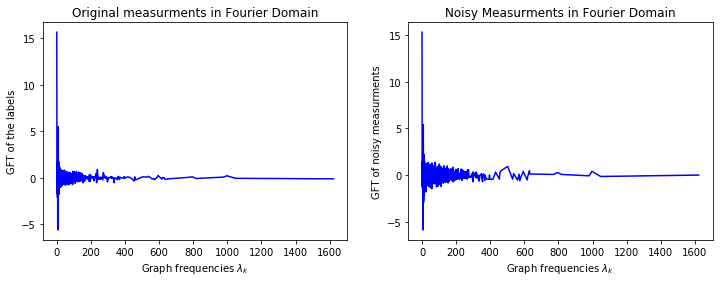

In [38]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1,2,1);
plt.plot(e, GFT(labels), c='blue')
plt.xlabel('Graph frequencies $\lambda_k$')
plt.ylabel('GFT of the labels')
plt.title('Original measurments in Fourier Domain')
plt.subplot(1,2,2);
plt.plot(e, GFT(noisy_measurements), c='blue')
plt.xlabel('Graph frequencies $\lambda_k$')
plt.ylabel('GFT of noisy measurments')
plt.title('Noisy Measurments in Fourier Domain')

### Question 10

In the denoising setting, a common graph signal processing assumption is that the signal $z$ that we want to recover is "smooth", in the sense that $\|\nabla_G z\|_2 = \sqrt{z^{\top} L z}$ is small, while remaining "close" to the measurements that we start with. This leads to denoising by solving the following optimization problem:

$$
z^\star = \text{arg} \, \underset{z \in \mathbb{R}^{N}}{\min} \, \|z - y\|_2^2 + \gamma z^{\top} L z, 
$$

where $y \in \mathbb{R}^{N}$ is the vector of noisy measurements.

Derive the close form solution to this problem giving $z^\star$ as a function of $y$, $\gamma$ and $L$. Does this solution correspond to any graph filtering operation that you know?

**Answer:**

Inspired by the derivation from *Graph Signal Processing* slide 8. (With $\tau = \frac{2}{\gamma}$)

$$
z^\star = \text{arg} \, \underset{z \in \mathbb{R}^{N}}{\min} \, \|z - y\|_2^2 + \gamma z^{\top} L z, 
$$

Derive by $z_\star$
$$
(z_\star-y) + \gamma L z_\star = 0
$$

Moving to the fourier domain (1):
$$
(\hat{z}_\star - \hat{y}) + \gamma \Lambda \hat{z}_\star = 0
$$

$$
\hat{z}_\star = (\gamma \Lambda + I)^{-1}\hat{y}
$$

Giving the element wise solution:
$$
\hat{z}_\star(l) = \frac{1}{1 + \gamma \lambda_l}\hat{y}(l)
$$

We recognize the `inverse_kernel` filter with parameter $t=\gamma$.


Note (1):

$GFT(L z_\star) = U^T L z_\star = U^T U \Lambda U^T z_\star = \Lambda \hat{z}_\star$

### Question 11

Now, denoise the noisy measurements by passing them through the filters that you implemented in Question 6. Choose the filter parameters based on the behavior of the GFT of your original label signal (this is the prior knowledge that you input to the problem).

In [39]:
# parameters are chosen comparing the measurements GFT and the filter kernel
z_heat_denoised = graph_filter(noisy_measurements, heat_kernel, t=0.05)
z_inv_denoised = graph_filter(noisy_measurements, inverse_kernel, t=0.05)
z_rect_denoised = graph_filter(noisy_measurements, rectangle_kernel, l_min=0, l_max=15)

Plot, on your graph, the original label signal, the noisy measurements, and the three denoised version obtained above. Report on each plot the value of the corresponding relative error 
$$
\text{rel-err} = \frac{\|\text{labels} - z \|_2}{\|\text{labels}\|_2},
$$
where $z$ is the plotted signal.

In [40]:
def rel_err(labels, z):
    return np.linalg.norm(labels - z, ord=2)/np.linalg.norm(labels, ord=2)

In [41]:
z_list = [labels, noisy_measurements, z_heat_denoised, z_inv_denoised, z_rect_denoised]
z_names = ['original measurements', 'noisy measurements', 'filtered heat kernel',
           'filtered inverse kernel', 'filtered rectangular kernel']

In [42]:
for i, (z, name) in enumerate(zip(z_list, z_names)):
    print(f'err={rel_err(labels, z):.3f} for {name}')

err=0.000 for original measurements
err=0.718 for noisy measurements
err=0.523 for filtered heat kernel
err=0.498 for filtered inverse kernel
err=0.600 for filtered rectangular kernel


In [43]:
# what is the maximum relative error ? 
rel_err(labels, 1-labels)

2.080683849848138

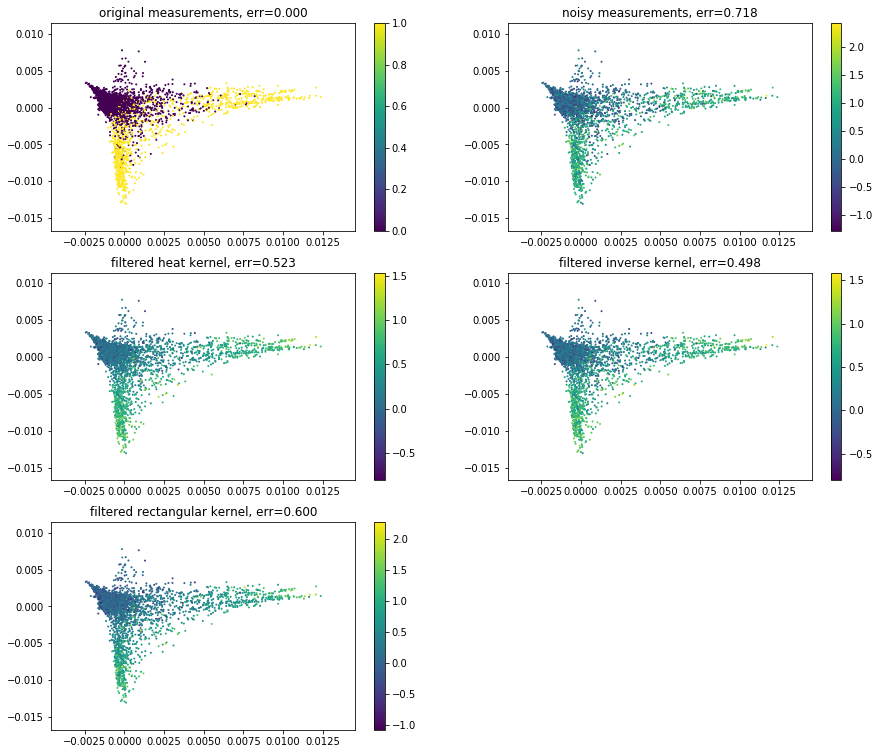

In [44]:
c = coords
plt.figure(figsize=(15,13))
for i, (z, name) in enumerate(zip(z_list, z_names)):
    plt.subplot(3,2,i+1); plot_graph(graph, c, z); plt.title(f'{name}, err={rel_err(labels, z):.3f}')

Finally, overlay on the same plot the GFT of all five signals above.

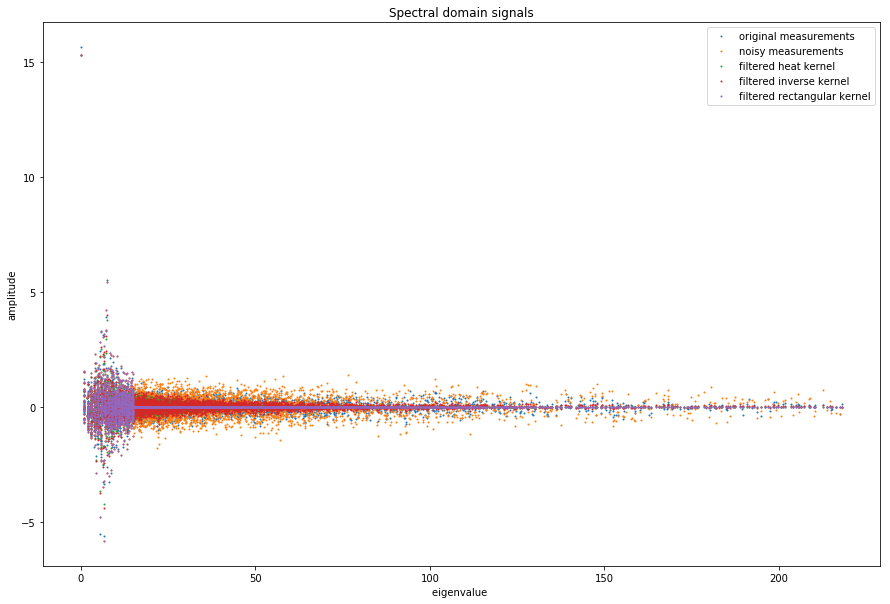

In [45]:
plt.figure(figsize=(15,10))
r = np.arange(n_nodes-100)
for i, (z, name) in enumerate(zip(z_list, z_names)):
    plt.plot(e[r],GFT(z)[r], '.', markersize=2, label=name)
plt.ylabel('amplitude')
plt.xlabel('eigenvalue ')
plt.title('Spectral domain signals')
plt.legend();

### Question 12

Comment on which denoised version seems to best match the original label signal. What is the underlying assumption behind the three filtering approaches? Do you think it holds for your label signal? Why?

**Answer:**

The signal filtered by the inverse kernel seems to best match the label signal.
The underlying assumption is that the signal we want to recover is smooth such that the high frequency noise can be filtered away. This assumption applies to our label signal as it is smooth, see question 5 for explanations. 



## 4 - Transductive learning

It is often the case in large networks that we can only afford to query properties/labels on a small subset of nodes. Nonetheless, if the underlying labels signal is "regular" enough, we might still be able to recover a good approximation of it by solving an offline variational problem, with constraints on the values of the measured nodes. 

In this section, we will be interested in solving such transductive learning problems by minimizing a (semi-) p-norm of the graph gradient applied to the signal of interest:

$$
\text{arg} \, \underset{z|_S = y}{\min} \|\nabla_G z\|_p^p,
$$

where $S$ is the set of measured nodes.

In English, we can say that we are looking for solutions with small "aggregated local variations", as measured by $\|\nabla_G z\|_p^p = \sum_{i=1}^{n} \sum_{j=1}^{n} \left( \sqrt{W_{ij}} |z[i] - z[j]| \right)^p,$ while satisfying the measurement constraints $z[i] = y[i]$ for $i \in S.$

We will work with two cases, according to the choices $p=1$ or $p=2.$ For $p=1,$ the problem is known as "interpolation by graph total-variation minimization," whereas for $p=2$ it is sometimes called "interpolation by Tikhonov regularization".

In order to solve these variational problems with the black-box solver provided to you, you will use the [pyunlocbox](https://pyunlocbox.readthedocs.io). This toolbox implements iterative solvers based on so-called ["proximal-splitting"](https://en.wikipedia.org/wiki/Proximal_gradient_method) methods.

### Question 13

Throughout this section, we will consider only a binarized version of your label signal. If your variable `labels` currently has values other than $\{-1, 1\},$ threshold them so that those are the only values taken in this vector. This can be done for example by choosing a number $t \in \mathbb{R}$ and then setting $\text{labels_bin}[i] = 1$ if $\text{labels}[i] \geq t$ and $\text{labels_bin}[i] = 0$ otherwise.

In [46]:
# unbalanced classes
len(labels[np.where(labels == 0)])

3529

In [47]:
# note we already have binary labels
np.unique(labels)

array([0, 1])

In [48]:
labels_bin = labels.copy()
labels_bin = labels_bin.astype('float')
labels_bin[np.where(labels_bin ==  0)] = -1.0

Now, subsample this binarized label signal by $70\%$ by choosing, uniformly at random, $30\%$ of the nodes whose labels we will keep.

You will do this by computing a "measurement mask" vector `w` with `1.0`'s at the measured coordinates, and $0.0$'s otherwise.

In [49]:
mn_ratio = 0.3
m = int(mn_ratio * n_nodes)  # Number of measurements.

# your code here
w = np.array([1] * m + [0] * (n_nodes-m))
np.random.shuffle(w) #inplace shuffle

In [50]:
## create equivalent function, to be used later 
def create_mask(mn_ratio):
    m = int(mn_ratio * n_nodes)  # Number of measurements.
    w = np.array([1] * m + [0] * (n_nodes-m))
    np.random.shuffle(w) #inplace shuffle
    return w

Plot the subsampled signal on the graph. _Hint:_ you might want to set to `numpy.nan` the values of the un-measured nodes for a cleaner plot.

In [51]:
# Your code here.
labels_bin_samp = labels_bin.copy()
labels_bin_samp[np.where(w==0)] = np.nan
labels_bin_samp

array([nan, -1., -1., ..., nan, nan, nan])

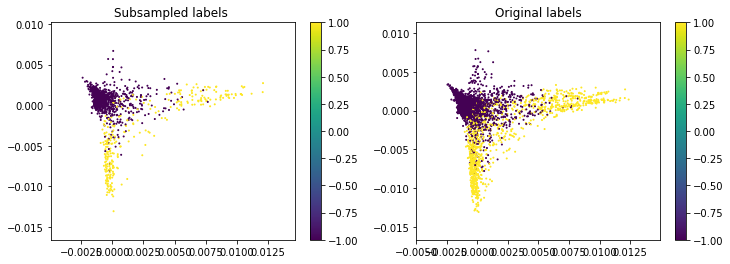

In [52]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plot_graph(graph, coords, labels_bin_samp);
plt.title('Subsampled labels ')
plt.subplot(1,2,2); plot_graph(graph, coords, labels_bin);
plt.title('Original labels');

### Interlude

For the solution of the variational problems you can use the following function as a "black-box". 

You will just need to provide a `gradient` matrix (which you should already have from Section 0), and an orthogonal projection operator `P` onto the span of the measured coordinates (made precise in the next question).

In [53]:
def graph_pnorm_interpolation(gradient, P, x0=None, p=1., **kwargs):
    r"""
    Solve an interpolation problem via gradient p-norm minimization.

    A signal :math:`x` is estimated from its measurements :math:`y = A(x)` by solving
    :math:`\text{arg}\underset{z \in \mathbb{R}^n}{\min}
    \| \nabla_G z \|_p^p \text{ subject to } Az = y` 
    via a primal-dual, forward-backward-forward algorithm.

    Parameters
    ----------
    gradient : array_like
        A matrix representing the graph gradient operator
    P : callable
        Orthogonal projection operator mapping points in :math:`z \in \mathbb{R}^n` 
        onto the set satisfying :math:`A P(z) = A z`.
    x0 : array_like, optional
        Initial point of the iteration. Must be of dimension n.
        (Default is `numpy.random.randn(n)`)
    p : {1., 2.}
    kwargs :
        Additional solver parameters, such as maximum number of iterations
        (maxit), relative tolerance on the objective (rtol), and verbosity
        level (verbosity). See :func:`pyunlocbox.solvers.solve` for the full
        list of options.

    Returns
    -------
    x : array_like
        The solution to the optimization problem.

    """
    
    grad = lambda z: gradient.dot(z)
    div = lambda z: gradient.transpose().dot(z)

    # Indicator function of the set satisfying :math:`y = A(z)`
    f = functions.func()
    f._eval = lambda z: 0
    f._prox = lambda z, gamma: P(z)

    # :math:`\ell_1` norm of the dual variable :math:`d = \nabla_G z`
    g = functions.func()
    g._eval = lambda z: np.sum(np.abs(grad(z)))
    g._prox = lambda d, gamma: functions._soft_threshold(d, gamma)

    # :math:`\ell_2` norm of the gradient (for the smooth case)
    h = functions.norm_l2(A=grad, At=div)

    stepsize = (0.9 / (1. + scipy.sparse.linalg.norm(gradient, ord='fro'))) ** p

    solver = solvers.mlfbf(L=grad, Lt=div, step=stepsize)

    if p == 1.:
        problem = solvers.solve([f, g, functions.dummy()], x0=x0, solver=solver, **kwargs)
        return problem['sol']
    if p == 2.:
        problem = solvers.solve([f, functions.dummy(), h], x0=x0, solver=solver, **kwargs)
        return problem['sol']
    else:
        return x0

### Question 14

During the iterations of the algorithm used for solving the variational problem, we have to make sure that the labels at the measured nodes stay the same. We will do this by means of an operator `P` which, given a vector $a \in \mathbb{R}^{N},$ returns another vector $b \in \mathbb{R}^{N}$ satisfying $b[i] = \text{labels_bin}[i]$ for every node $i$ in the set $S$ of known labels, and $b[i] = a[i]$ otherwise. Write in the cell below the function for this orthogonal projection operator `P`.

_Hint:_ remember you have already computed the mask `w`.

In [54]:
def P(a):
    # Your code here.
    b = a.copy()
    b[np.where(w==1.)] = labels_bin[np.where(w==1.)]
    return b

### Question 15

Solve the variational problems for $p = 1$ and $p = 2$. Record the solution for the $1-$norm minimization under `sol_1norm_min` and the one for $2-$norm minimization under `sol_2norm_min`.

Compute also binarized versions of these solutions by thresholding the values with respect to $0$, that is, non-negative values become `1.0`, while negative values become `-1.0`. Store those binarized versions under `sol_1norm_bin` and `sol_2norm_bin`, respectively.

In [99]:
# try random initialization
#x0 = np.random.randn(n_nodes) # note: this is the "default" in the black box function

# try reusing the known subsampled label vector
x0 = labels_bin_samp.copy()

# try normal distribution initialization
#x0[np.where(w==0)] = np.random.randn(n_nodes)[np.where(w==0)]

# try uniform distribution initialization
#x0[np.where(w==0)] = np.random.uniform(-1, 1, n_nodes)[np.where(w==0)]

# best results when just setting to 0 (center of (-1, 1))
x0[np.where(w==0)] = 0

sol_1norm_min = graph_pnorm_interpolation(gradient = gradient, P=P,x0=x0.copy() , p=1.0 )
sol_2norm_min = graph_pnorm_interpolation(gradient = gradient, P=P,x0=x0.copy() , p=2.0 )

Solution found after 47 iterations:
    objective function f(sol) = 5.269586e+05
    stopping criterion: RTOL
Solution found after 1 iterations:
    objective function f(sol) = 1.033387e+05
    stopping criterion: RTOL


In [75]:
(sol_2norm_min == sol_1norm_min).all()

False

In [76]:
threshold = 0

sol_1norm_bin = np.array([1.0 if sol_1norm_min[i] >= threshold else -1.0 for i in range(n_nodes)])
sol_2norm_bin = np.array([1.0 if sol_2norm_min[i] >= threshold else -1.0 for i in range(n_nodes)])

In [77]:
# create equivalent function to be used later 
def binarize_array(a, threshold):
    n = len(a)
    b = np.array([1.0 if a[i] >= threshold else -1.0 for i in range(n) ])
    return b

Plot, on your graph, the original `labels_bin` signal, as well as the solutions to the variational problems (both binarized and otherwise). Indicate on each plot the value of the relative error $\text{rel-err} = \frac{\|\text{labels_bin} - z\|_2}{\|\text{labels_bin}\|_2}$, where $z$ is the signal in the corresponding plot.

In [78]:
z_list = [labels_bin, None, sol_1norm_min, sol_1norm_bin, sol_2norm_min, sol_2norm_bin]
z_names = ['original measurements', None, 'sol_p1_real','sol_p1_bin','sol_p2_real', 'sol_p2_bin']

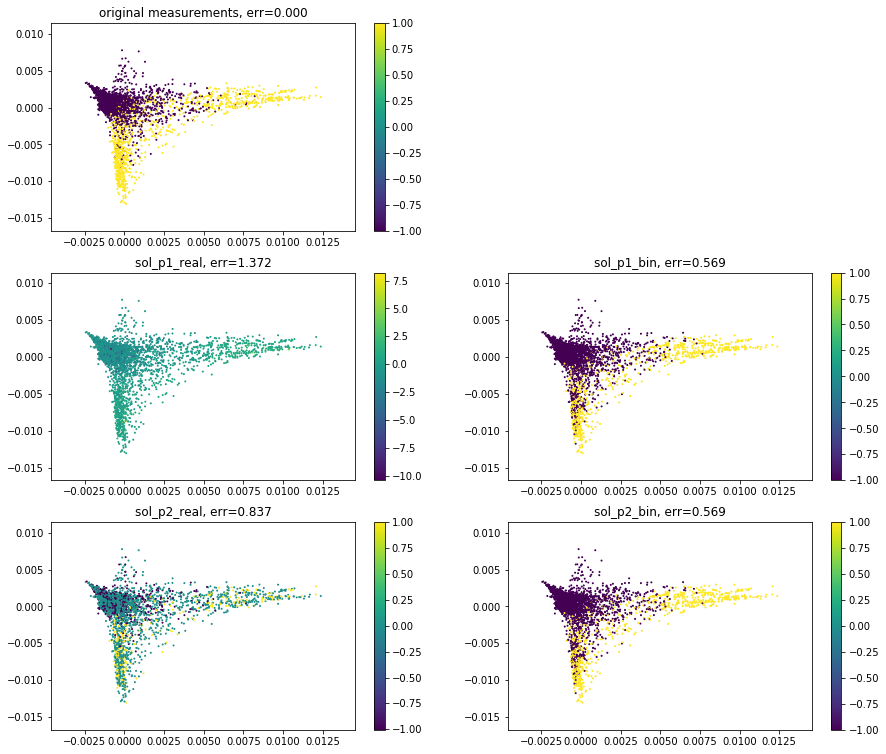

In [79]:
c = coords
plt.figure(figsize=(15,13))
for i, (z, name) in enumerate(zip(z_list, z_names)):
    if z is None: continue
    plt.subplot(3,2,i+1); plot_graph(graph, c, z); plt.title(f'{name}, err={rel_err(labels_bin, z):.3f}')

### Question 16

Now that you have got a feeling for the sort of solutions that the transductive learning problems studied can give, we will see what is the effect of the number of measurements on the accuracy of both $p-$norm minimization problems.

Towards this goal, you will write a `phase_transition()` function. This function will basically go over all the procedures that you have implemented in this section, but for varying numbers of measurements and thresholding values. It will also compute the relative error, $\text{rel-err},$ of the solutions and average them over a number of trials.

The output of the `phase_transition()` function has to be a matrix with `len(mn_ratios)` columns and `len(thresholds)` rows. Each pixel $(i,j)$ in the output matrix has to contain the average, over `n_trials` trials, of the relative error $\text{rel-err}$ in the binarized (with threshold `thresholds[i]`) solution given by `graph_pnorm_interpolation()` from observing an `mn_ratios[j]` fraction of nodes. The randomness comes from a different choice of mask `w` at each trial, hence the averaging.

The interest of this phase transition matrix is to assess what level of recovery error one could expect for a certain fraction of measurements and a certain threshold level.

In [73]:
def phase_transition(mn_ratios, thresholds, n_trials, labels_bin, p):
    
    pt_matrix = np.zeros(( len(thresholds), len(mn_ratios)))
    
    for trial in range(0, n_trials):
        for i_rat, mn_ratio in enumerate(mn_ratios):
            # Create sample mask.
            w = create_mask(mn_ratio)
            # recreate P function according to the mask.
            def P_inner(a):
                b = a.copy()
                b[np.where(w==1.)] = labels_bin[np.where(w==1.)]
                return b
            
            # Solve p-norm interpolation.
            #x0 = np.random.randn(n_nodes) # note: this is the "default" in the black box function
            x0 = P_inner(np.zeros(n_nodes))
            sol = graph_pnorm_interpolation(gradient=gradient, P=P_inner, x0=x0.copy(), p=p)
            # binarize
            for i_thres, threshold in enumerate(thresholds):
                sol_bin = binarize_array(sol, threshold)
                err = rel_err(labels_bin, sol_bin )
                pt_matrix[i_thres, i_rat] = pt_matrix[i_thres, i_rat] + err
    # Aggregate: divide each element of matrix by number of trials to get the average
    pt_matrix = pt_matrix/n_trials
    return pt_matrix

### Question 17

Pick 5 "m/n" ratios in $(0, 1)$ and 5 threshold levels in $(-1, 1)$ and run the `phase_transition()` function with `n_trials` = 20, for both $p = 1$ and $p = 2$.

In [98]:
mn_ratios = np.linspace(start=0.1, stop= 0.9, num=5)
thresholds =  np.linspace(start=-0.9, stop= 0.9, num=5)
n_trials = 20

pt_matrix_1norm = phase_transition(mn_ratios, thresholds, n_trials=n_trials, labels_bin=labels_bin, p =1.0)
pt_matrix_2norm = phase_transition(mn_ratios, thresholds, n_trials=n_trials, labels_bin=labels_bin, p =2.0)


Solution found after 70 iterations:
    objective function f(sol) = 2.055797e+05
    stopping criterion: RTOL


KeyboardInterrupt: 

Plot both phase transition matrices as images with a colorbar. Make sure to properly name the axes and title the images. 

In [70]:
pt_matrix_1norm

array([[1.57862161, 0.81711908, 0.54678681, 0.4940262 , 0.27537886],
       [1.41529176, 0.64141922, 0.43790742, 0.38380826, 0.20023956],
       [0.63183504, 0.54198332, 0.44285569, 0.33920163, 0.16960082],
       [0.89110762, 0.67776053, 0.51306742, 0.45258994, 0.23246994],
       [0.90710375, 0.7653421 , 0.57854425, 0.49841763, 0.27852615]])

In [71]:
def plot_phase_transition_mat(mat, title):
    plt.imshow(mat, cmap='hot', origin='lower')
    plt.gca().set_xticks(range(len(mn_ratios)));
    plt.gca().set_xticklabels([round(i, 2) for i in mn_ratios]);
    plt.xlabel('"m/n" ratio')
    plt.gca().set_yticks(range(len(thresholds)));
    plt.gca().set_yticklabels([round(i, 2) for i in thresholds]);
    plt.ylabel('threshold')
    plt.title(title)
    plt.colorbar()

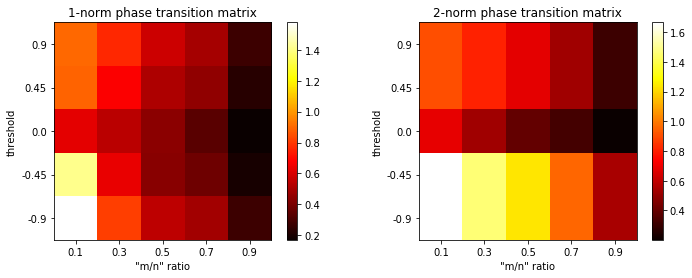

In [72]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_phase_transition_mat(pt_matrix_1norm, '1-norm phase transition matrix')
plt.subplot(1,2,2)
plot_phase_transition_mat(pt_matrix_2norm, '2-norm phase transition matrix')
# TODO: same color range!

### Question 18

Do the phase transition plots above provide any justification for choosing one $p-$norm interpolation over the other? Why?

**Answer:**

The 1-norm is preferred, since changing the threshold for a given m/n ratio has a smaller influence on the relative error than for the 2-norm. This means that the 1-norm interpolation results in "stronger" labels.

This is most visible in the column with the highest m/n ratio: changing the threshold for the 1-norm interpolation changes the relative error very little.